# 💡 Image Thresholding in OpenCV (Python Tutorial)

This `Jupyter Notebook` provides a comprehensive guide to image thresholding techniques using the `OpenCV` library in Python. It covers the three main types of thresholding:

1.  **Simple (Global) Thresholding**
2.  **Adaptive Thresholding**
3.  **Otsu's Binarization (Automatic Thresholding)**

Each section includes the mathematical foundation, the corresponding OpenCV function, and runnable code examples with visualizations using Matplotlib.

## 1. Imports and Setup

In [19]:
# Import all dependencies
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tools.tools import LearnTools

learn_tools = LearnTools()
%matplotlib inline

# 2. Load Image

In [20]:
# Image URLs
img_url = "https://i.ibb.co/5x276TvQ/1.jpg"
# img_url = "https://i.ibb.co/QjkCQ6Vm/2.jpg"
# img_url = "https://preview.redd.it/show-me-the-last-lines-from-what-youve-been-reading-v0-hw2yga9ddtxc1.jpeg?auto=webp&s=98baa1ed018702096a1ece0012f39ea898f2fea2"

Image Created


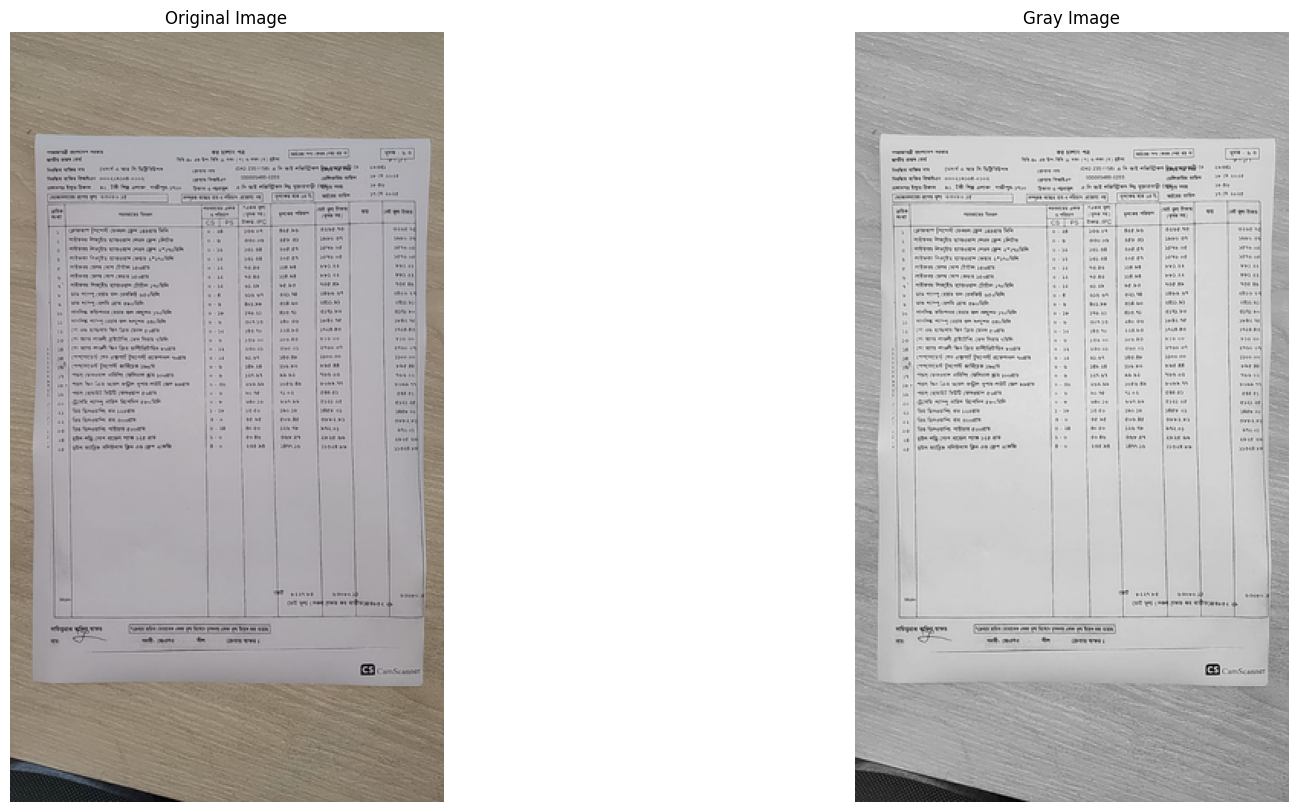

In [21]:
# Find and Load the image

if os.path.exists('testImage.jpeg'):
    image = cv2.imread('testImage.jpeg')
    print('Image Exists')
elif not os.path.exists('testImage.jpg'):
    image_url = img_url
    pil_image = await learn_tools.get_image(img_url=image_url, padding=0)
    pil_image.save('testImage.jpg', 'JPEG')
    # or
    image = learn_tools.pil_to_cv2(pil_image=pil_image)
    # cv2.imwrite('testImage.jpg', image)
    print('Image Created')

if image is not None:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    # Display the images using LearnTools
    learn_tools.show_multiple_images(
        image_plotting_data=[
            {'title': 'Original Image','image': image},
            {'title': 'Gray Image','image': gray_image}
        ]
    )
else:
    print('The image could not be loaded.')


## 2. Simple (Global) Thresholding

Simple Thresholding applies a single, fixed threshold value ($T$) across the entire image. If a pixel value $p(x,y)$ is greater than $T$, it is assigned one value (`MaxVal`); otherwise, it is assigned another value (usually 0 or `MaxVal`).

### Mathematical Formulation

The generic function for the output pixel $p'(x,y)$ is:
$$ p'(x,y) = f(p(x,y), T, \text{MaxVal}) $$

For the most common type, **Binary Thresholding** (`cv.THRESH_BINARY`):
$$ 
p'(x,y) = \begin{cases} \text{MaxVal} & \text{if } p(x,y) > T \\ 0 & \text{if } p(x,y) \le T \end{cases} 
$$

### OpenCV Implementation

The core function is `cv.threshold(src, thresh, maxval, type)`.

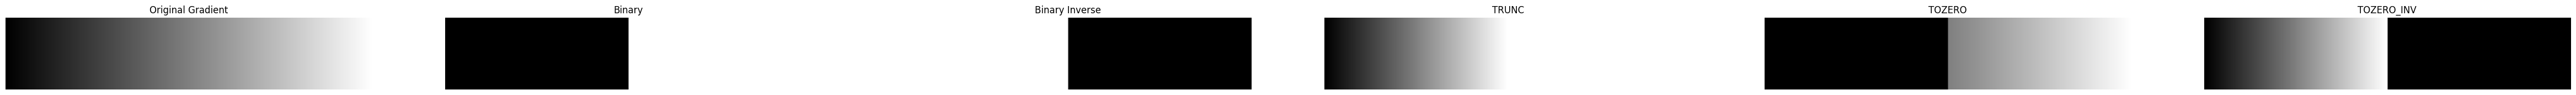

In [22]:
# Parameters for thresholding
thresh_val = 127       # Threshold value T
max_val = 255          # Maximum value to use for pixels exceeding the threshold


# Create a synthetic gradient image
# This helps visualize how thresholding affects pixel intensities
# The image will have 50 rows, each with values 0..255
gradient = np.linspace(0, 255, 256, dtype=np.uint8)
img_simple = np.tile(gradient, (50, 1))

# Apply different simple thresholding techniques
# 1. THRESH_BINARY: pixels > T become MaxVal, else 0
ret, thresh1 = cv2.threshold(img_simple, thresh_val, max_val, cv2.THRESH_BINARY)

# 2. THRESH_BINARY_INV: pixels > T become 0, else MaxVal
ret, thresh2 = cv2.threshold(img_simple, thresh_val, max_val, cv2.THRESH_BINARY_INV)

# 3. THRESH_TRUNC: pixels > T become T, else unchanged
ret, thresh3 = cv2.threshold(img_simple, thresh_val, max_val, cv2.THRESH_TRUNC)

# 4. THRESH_TOZERO: pixels > T unchanged, else 0
ret, thresh4 = cv2.threshold(img_simple, thresh_val, max_val, cv2.THRESH_TOZERO)

# 5. THRESH_TOZERO_INV: pixels > T become 0, else unchanged
ret, thresh5 = cv2.threshold(img_simple, thresh_val, max_val, cv2.THRESH_TOZERO_INV)

# Display images after adding filters
learn_tools.show_multiple_images(
    image_plotting_data=[
        {'title': 'Original Gradient', 'image': img_simple},
        {'title': 'Binary', 'image': thresh1},
        {'title': 'Binary Inverse', 'image': thresh2},
        {'title': 'TRUNC', 'image': thresh3},
        {'title': 'TOZERO', 'image': thresh4},
        {'title': 'TOZERO_INV', 'image': thresh5}
    ]
)


### Simple Thresholding Types

| Type | Condition $p(x,y) > T$ | Condition $p(x,y) \le T$ |
| :--- | :--- | :--- |
| `THRESH_BINARY` | $p'(x,y) = \text{MaxVal}$ | $p'(x,y) = 0$ |
| `THRESH_BINARY_INV`| $p'(x,y) = 0$ | $p'(x,y) = \text{MaxVal}$ |
| `THRESH_TRUNC` | $p'(x,y) = T$ | $p'(x,y) = p(x,y)$ |
| `THRESH_TOZERO` | $p'(x,y) = p(x,y)$ | $p'(x,y) = 0$ |
| `THRESH_TOZERO_INV`| $p'(x,y) = 0$ | $p'(x,y) = p(x,y)$ |

## 3. Adaptive Thresholding

Adaptive Thresholding is used when the image has **varying illumination**. Instead of a global $T$, the algorithm calculates a *local* threshold value $T_{\text{local}}(x,y)$ for a small neighborhood around each pixel $(x,y)$.

### Mathematical Formulation

The local threshold $T_{\text{local}}(x,y)$ is determined based on the neighborhood $N(x,y)$ defined by `blockSize`. After computing $T_{\text{local}}(x,y)$, the pixel $p(x,y)$ is compared against it using a binary rule (e.g., `THRESH_BINARY`).

The output pixel $p'(x,y)$ for `THRESH_BINARY` is:
$$ p'(x,y) = \begin{cases} \text{MaxVal} & \text{if } p(x,y) > T_{\text{local}}(x,y) \\ 0 & \text{if } p(x,y) \le T_{\text{local}}(x,y) \end{cases} $$

Where $T_{\text{local}}(x,y)$ is calculated by one of two methods:

1.  **Mean Method (`ADAPTIVE_THRESH_MEAN_C`)**:
    $$ T_{\text{local}}(x,y) = \text{Mean}(N(x,y)) - C $$

2.  **Gaussian Method (`ADAPTIVE_THRESH_GAUSSIAN_C`)**:
    $$ T_{\text{local}}(x,y) = \sum_{i,j \in N(x,y)} p(i,j) \cdot G(i,j) - C $$
    $G(i,j)$ is a Gaussian window (weight) applied to the neighborhood pixels.

### OpenCV Implementation

The function is `cv.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)`.

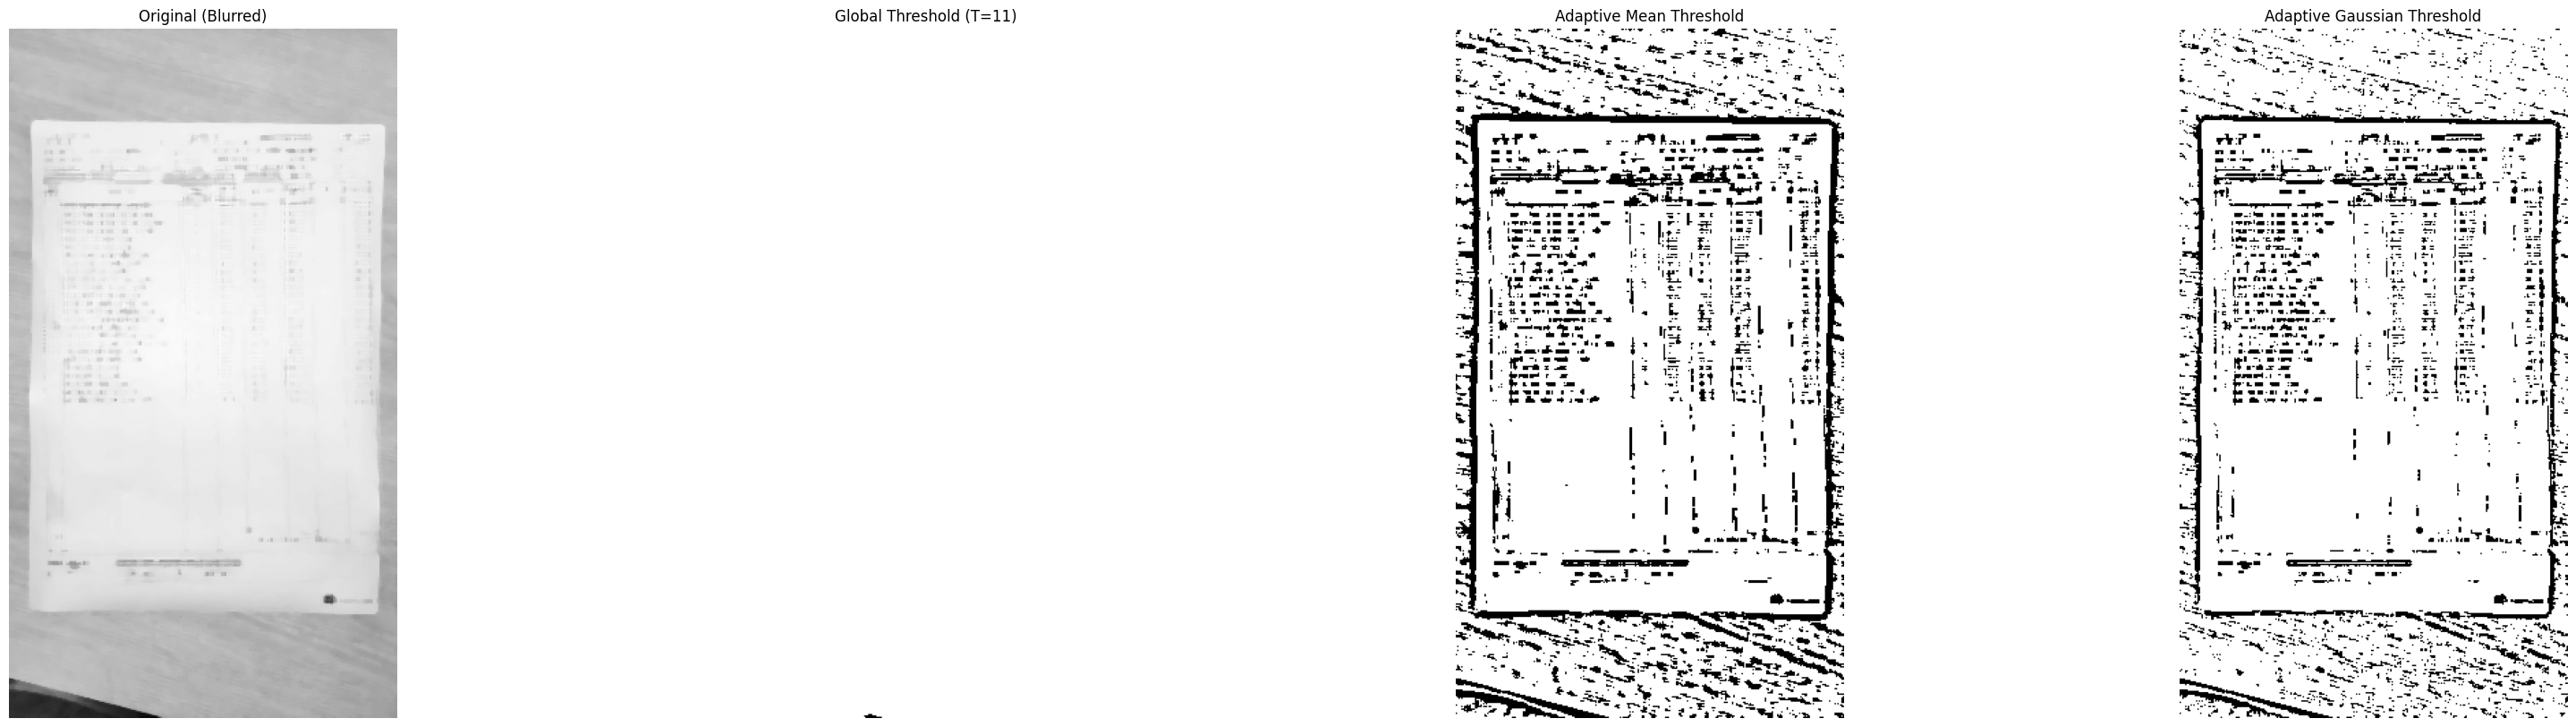

In [23]:
# Use the original image (sudoku.png) which has varying illumination
img = image.copy()

# ✅ Ensure grayscale BEFORE any thresholding
if len(img.shape) == 3:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    gray = img.copy()


# 1. Pre-processing: Median blur (recommended for adaptive thresholding)
img_blur = cv2.medianBlur(gray, 5)

# Parameters
max_val_adaptive = 255
block_size = 11   # MUST be odd and > 1
C_constant = 2

# ✅ Safety check
if block_size % 2 == 0 or block_size <= 1:
    raise ValueError("block_size must be an odd number > 1")

# 2. Global Thresholding (for comparison)
_, th1 = cv2.threshold(img_blur, 11, max_val_adaptive, cv2.THRESH_BINARY)

# 3. Adaptive Mean Thresholding
th2 = cv2.adaptiveThreshold(
    img_blur,
    max_val_adaptive,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY,
    block_size,
    C_constant
)

# 4. Adaptive Gaussian Thresholding
th3 = cv2.adaptiveThreshold(
    img_blur,
    max_val_adaptive,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    block_size,
    C_constant
)

# Display images after adding filter
learn_tools.show_multiple_images(
    image_plotting_data=[
        {'title': 'Original (Blurred)', 'image': img_blur},
        {'title': 'Global Threshold (T=11)', 'image': th1},
        {'title': 'Adaptive Mean Threshold', 'image': th2},
        {'title': 'Adaptive Gaussian Threshold', 'image': th3}
    ]
)

## 4. Otsu's Binarization

Otsu's method automatically calculates an optimal global threshold $T^*$ for an image, typically used for **bimodal images** (images whose histogram has two distinct peaks). It avoids the need to manually choose $T$.

### Mathematical Formulation

Otsu's method works by iterating through all possible threshold values $T$ and selecting the value that **minimizes the weighted within-class variance** (or, equivalently, maximizes the between-class variance). 

The weighted within-class variance $\sigma^2_w(T)$ is defined as:
$$ \sigma^2_w(T) = \omega_1(T)\sigma_1^2(T) + \omega_2(T)\sigma_2^2(T) $$

Where:
* $\omega_1(T)$ and $\omega_2(T)$: The probabilities (weights) of the two classes (foreground and background) separated by threshold $T$.
* $\sigma_1^2(T)$ and $\sigma_2^2(T)$: The variances of the two classes.

The optimal threshold $T^*$ is found where $\sigma^2_w(T)$ is minimal:
$$ T^* = \arg \min_{0 \le T < 256} \left[ \omega_1(T)\sigma_1^2(T) + \omega_2(T)\sigma_2^2(T) \right] $$

### OpenCV Implementation

To use Otsu's method, you pass the `cv.THRESH_OTSU` flag along with the desired threshold type (e.g., `cv.THRESH_BINARY`) to `cv.threshold()`. The explicit `thresh` parameter is often set to **0** and is ignored, as the optimal value is calculated and returned as the first output parameter (`ret`).

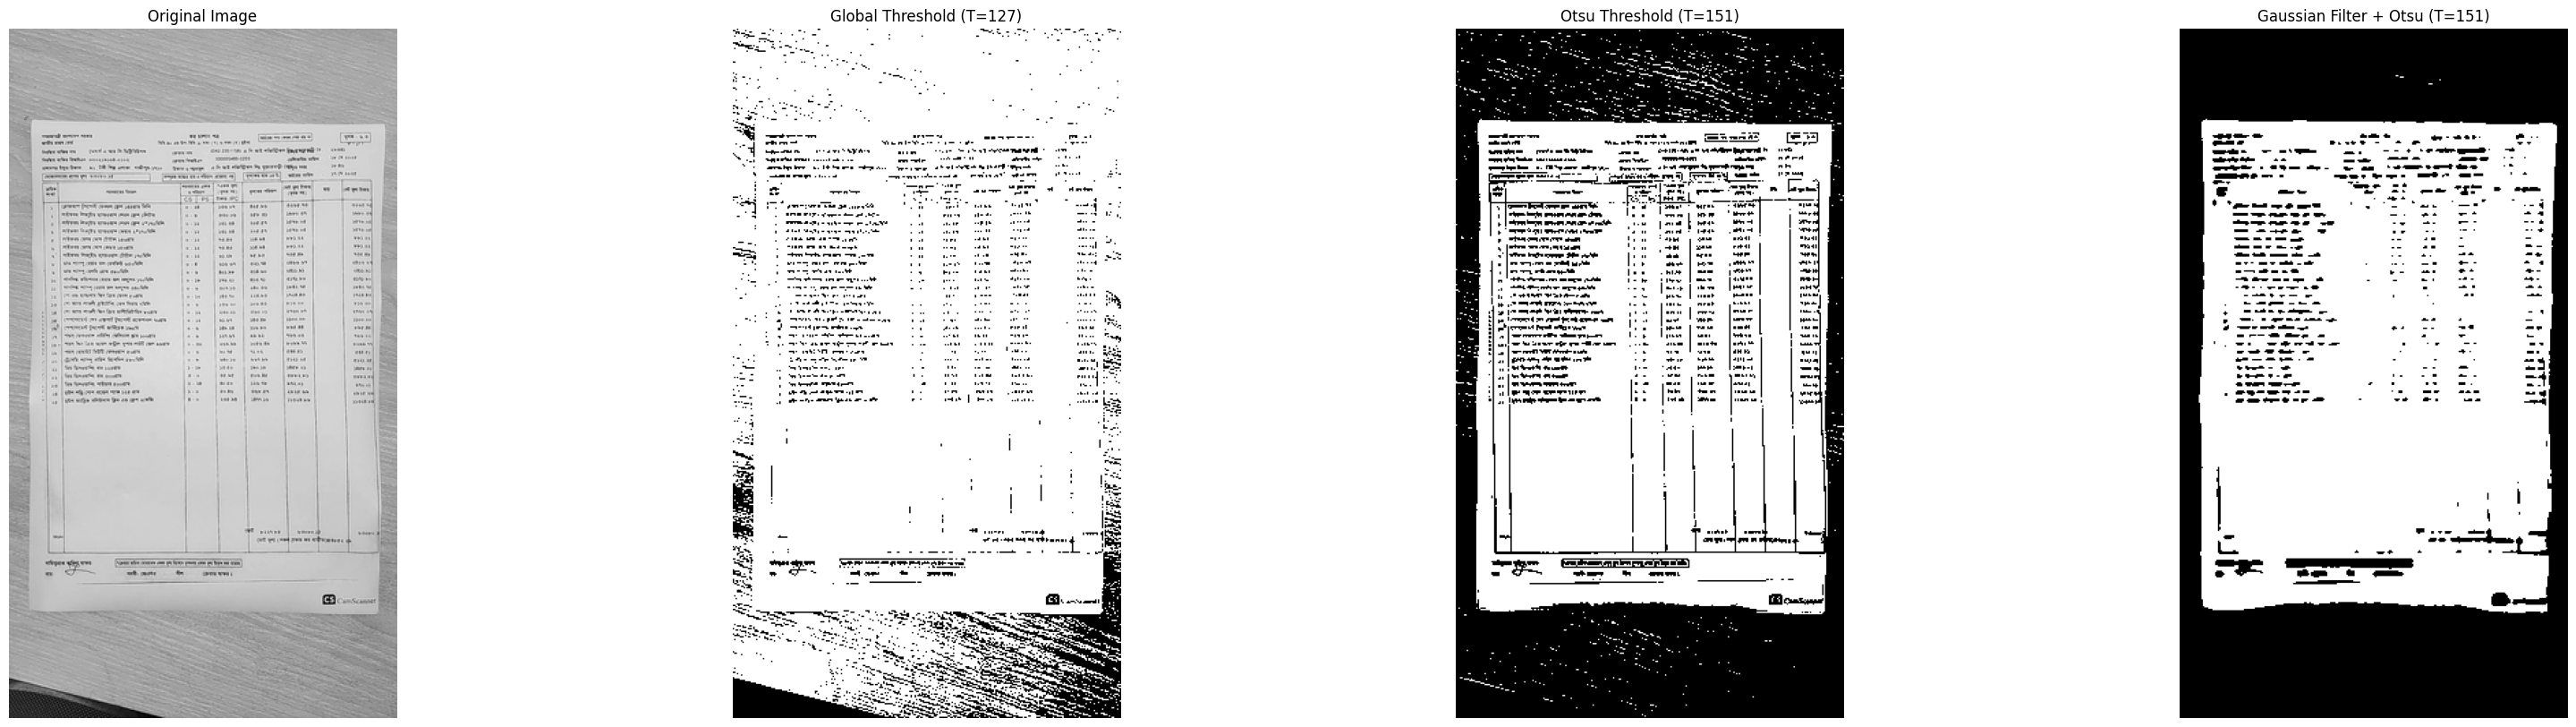


--- Otsu's Auto-Calculated Thresholds ---
Otsu's T (No Filter): 151
Otsu's T (With Gaussian Filter): 151


In [24]:
# Ensure grayscale for Otsu's thresholding
if len(image.shape) == 3:
    img_otsu = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
else:
    img_otsu = image.copy()

# 1. Global Thresholding (Manual T=127)
ret1, th1 = cv2.threshold(img_otsu, 127, 255, cv2.THRESH_BINARY)

# 2. Otsu's Thresholding (Automatic T)
ret2, th2 = cv2.threshold(img_otsu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3. Gaussian Filter + Otsu's Thresholding (Best Practice)
blur = cv2.GaussianBlur(img_otsu, (5, 5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Display images after adding filter
learn_tools.show_multiple_images(
    image_plotting_data=[
        {'title': 'Original Image', 'image': img_otsu},
        {'title': 'Global Threshold (T=127)', 'image': th1},
        {'title': f'Otsu Threshold (T={int(ret2)})', 'image': th2},
        {'title': f'Gaussian Filter + Otsu (T={int(ret3)})', 'image': th3}
    ]
)

# Plot results + histogram
print(f"\n--- Otsu's Auto-Calculated Thresholds ---")
print(f"Otsu's T (No Filter): {int(ret2)}")
print(f"Otsu's T (With Gaussian Filter): {int(ret3)}")


## Summary of Best Practices

| Scenario | Best Thresholding Method | Key Parameters |
| :--- | :--- | :--- |
| **Uniform Lighting** | Simple (Global) Thresholding | `thresh` (Manual) |
| **Uniform Lighting, Bimodal Histogram** | **Otsu's Binarization** | `cv.THRESH_OTSU` |
| **Non-Uniform Lighting** | **Adaptive Thresholding** | `blockSize`, `C`, `adaptiveMethod` |
| **Noisy Image** | Gaussian/Median Filter $\rightarrow$ Otsu or Adaptive | Filter kernel size |

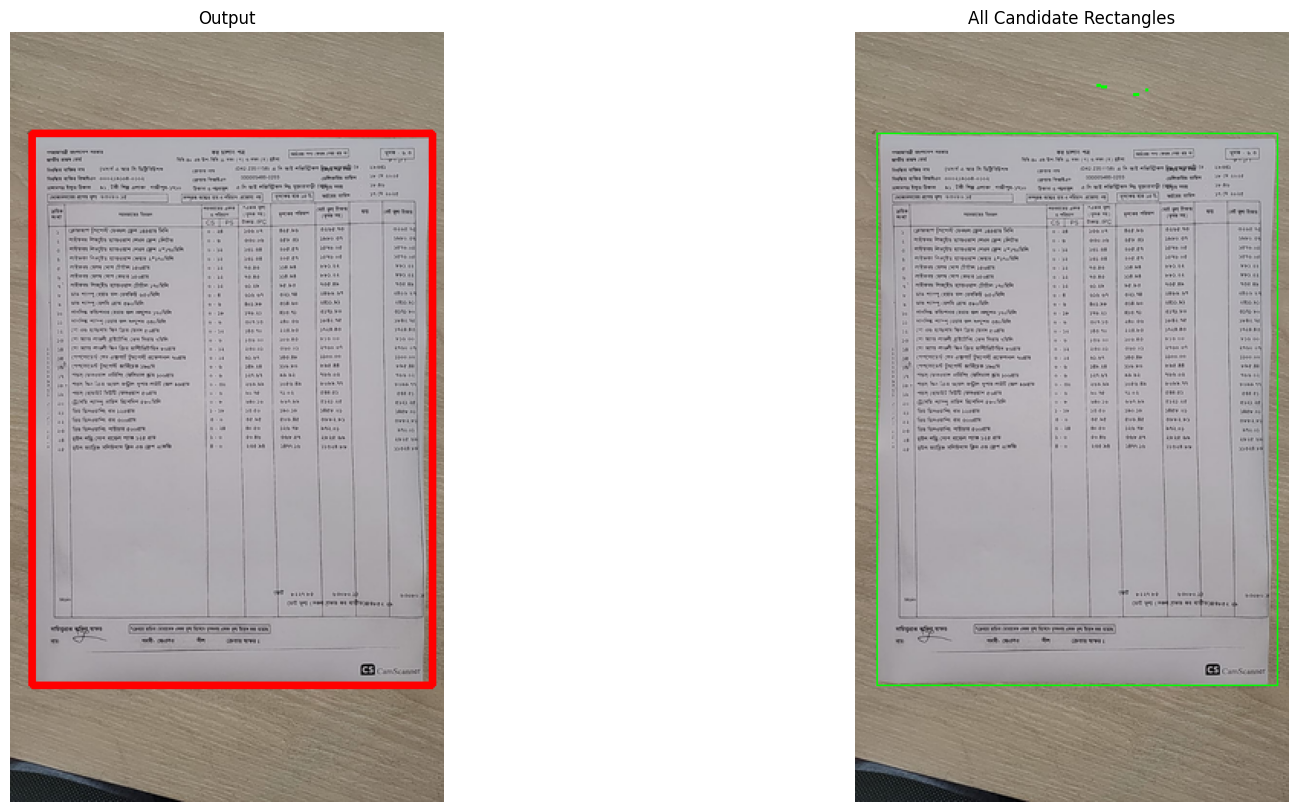

In [ ]:
# Use Case
def draw_biggest_white_rectangle(binary_image, original_image, debug=False):
    """
    Finds and draws a rectangle around the largest white region
    in a binary image (white = 255).

    Args:
        binary_image (np.ndarray): Thresholded image (0/255)
        original_image (np.ndarray): Original full-color image
        debug (bool): If True, returns a preview with contour areas

    Returns:
        output_img: original image with drawn rectangle
        bbox: (x, y, w, h)
    """

    # Ensure binary is uint8 (important)
    bin_img = binary_image.copy().astype("uint8")

    # Find contours of WHITE regions
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No white regions found in thresholded image.")

    # Pick the largest connected white region
    biggest = max(contours, key=cv2.contourArea)

    # Rectangle around that region
    x, y, w, h = cv2.boundingRect(biggest)

    # Draw on original image
    output = original_image.copy()
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 3)

    if debug:
        debug_img = original_image.copy()
        for cnt in contours:
            ax, ay, aw, ah = cv2.boundingRect(cnt)
            cv2.rectangle(debug_img, (ax, ay), (ax + aw, ay + ah), (0, 255, 0), 1)
        return output, (x, y, w, h), debug_img

    return output, (x, y, w, h)

out, bbox, dbg = draw_biggest_white_rectangle(th3, image, debug=True)
learn_tools.show_multiple_images([
    {"title": "Output", "image": out},
    {"title": "All Candidate Rectangles", "image": dbg},
])
